## E17. 다양한 OCR모델 비교하기

### Step1. 검증용 데이터셋 준비

- 영어 필기체는 직접 써보고 읽어본 원어민이 아니면 읽기 힘든 경우가 가끔 있다. 필기체 읽기가 어려운 사람들도 쉽게 읽을 수 있도록 필기체를 인식하는 데이터 셋을 준비하였습니다.
- 필기체 이미지의 경우 데이터내의 텍스트가 많아 적은 이미지로도 충분히 ocr성능 비교가 가능하여 7개 이미지를 사용하여 테스트하였습니다.

### Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

In [1]:
def detect_text(path):
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content = content)
    
    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')
    
    for text in texts:
        print('\n"{}"'.format(text.description))
        
    vertices = (['({},{})'.format(vertex.x, vertex.y)
                for vertex in text.bounding_poly.vertices])
    
    print('bounds: {}'.format(','.join(vertices)))
    
    if response.error.message:
        raise Exception(
        '{}\nFor more info on error messages, check: '
        'https://cloud.google.com/apis/design/errors'.format(
        response.error.message))

In [2]:
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

image_paths = [
    '/home/aiffel/aiffel/ocr_python/images/img1.jpg',
    '/home/aiffel/aiffel/ocr_python/images/img2.jpg',
    '/home/aiffel/aiffel/ocr_python/images/img3.jpg',
    '/home/aiffel/aiffel/ocr_python/images/img4.png',
    '/home/aiffel/aiffel/ocr_python/images/img5.jpg',
    '/home/aiffel/aiffel/ocr_python/images/img6.jpeg',
    '/home/aiffel/aiffel/ocr_python/images/img7.jpg', 
]

for path in image_paths:
    detect_text(path)

-rw-rw-r-- 1 aiffel aiffel 2325 10월  7 10:02 /home/aiffel/aiffel/ocr_python/my_google_api_key.json
Texts:

"You can't let yout failure define
have to let them teach
you-you
you.You have to let them show
what to do differently
next len
you
"

"You"

"can't"

"let"

"yout"

"failure"

"define"

"have"

"to"

"let"

"them"

"teach"

"you-you"

"you.You"

"have"

"to"

"let"

"them"

"show"

"what"

"to"

"do"

"differently"

"next"

"len"

"you"
bounds: (222,465),(53,464),(53,381),(222,382)
Texts:

"Name :Ohakriti Malla
Class: 8 (Eight)
Sec: B
School:Sainik Awasiya Mahaviotyalaya
Handiriting is an essential skil( for bolh children and adult
(Frder & Majnemır. 2007) EEven in the age of lechnelogy, il
remccins the prinary leol of communication and knenledge
lassesstent for sludints in lht olassreem The demands for il
"

"Name"

":Ohakriti"

"Malla"

"Class:"

"8"

"(Eight)"

"Sec:"

"B"

"School:Sainik"

"Awasiya"

"Mahaviotyalaya"

"Handiriting"

"is"

"an"

"essential"

"skil("

"for"

"b

In [3]:
import matplotlib.pyplot as plt
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel/.keras-ocr/crnn_kurapan.h5


In [4]:
image_paths = [
    '/home/aiffel/aiffel/ocr_python/images/img1.jpg',
    '/home/aiffel/aiffel/ocr_python/images/img2.jpg',
    '/home/aiffel/aiffel/ocr_python/images/img3.jpg',
    '/home/aiffel/aiffel/ocr_python/images/img4.png',
    '/home/aiffel/aiffel/ocr_python/images/img5.jpg',
    '/home/aiffel/aiffel/ocr_python/images/img6.jpeg',
    '/home/aiffel/aiffel/ocr_python/images/img7.jpg', 
]


images = [keras_ocr.tools.read(path) for path in image_paths]
prediction_groups = [pipeline.recognize([path]) for path in image_paths]

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


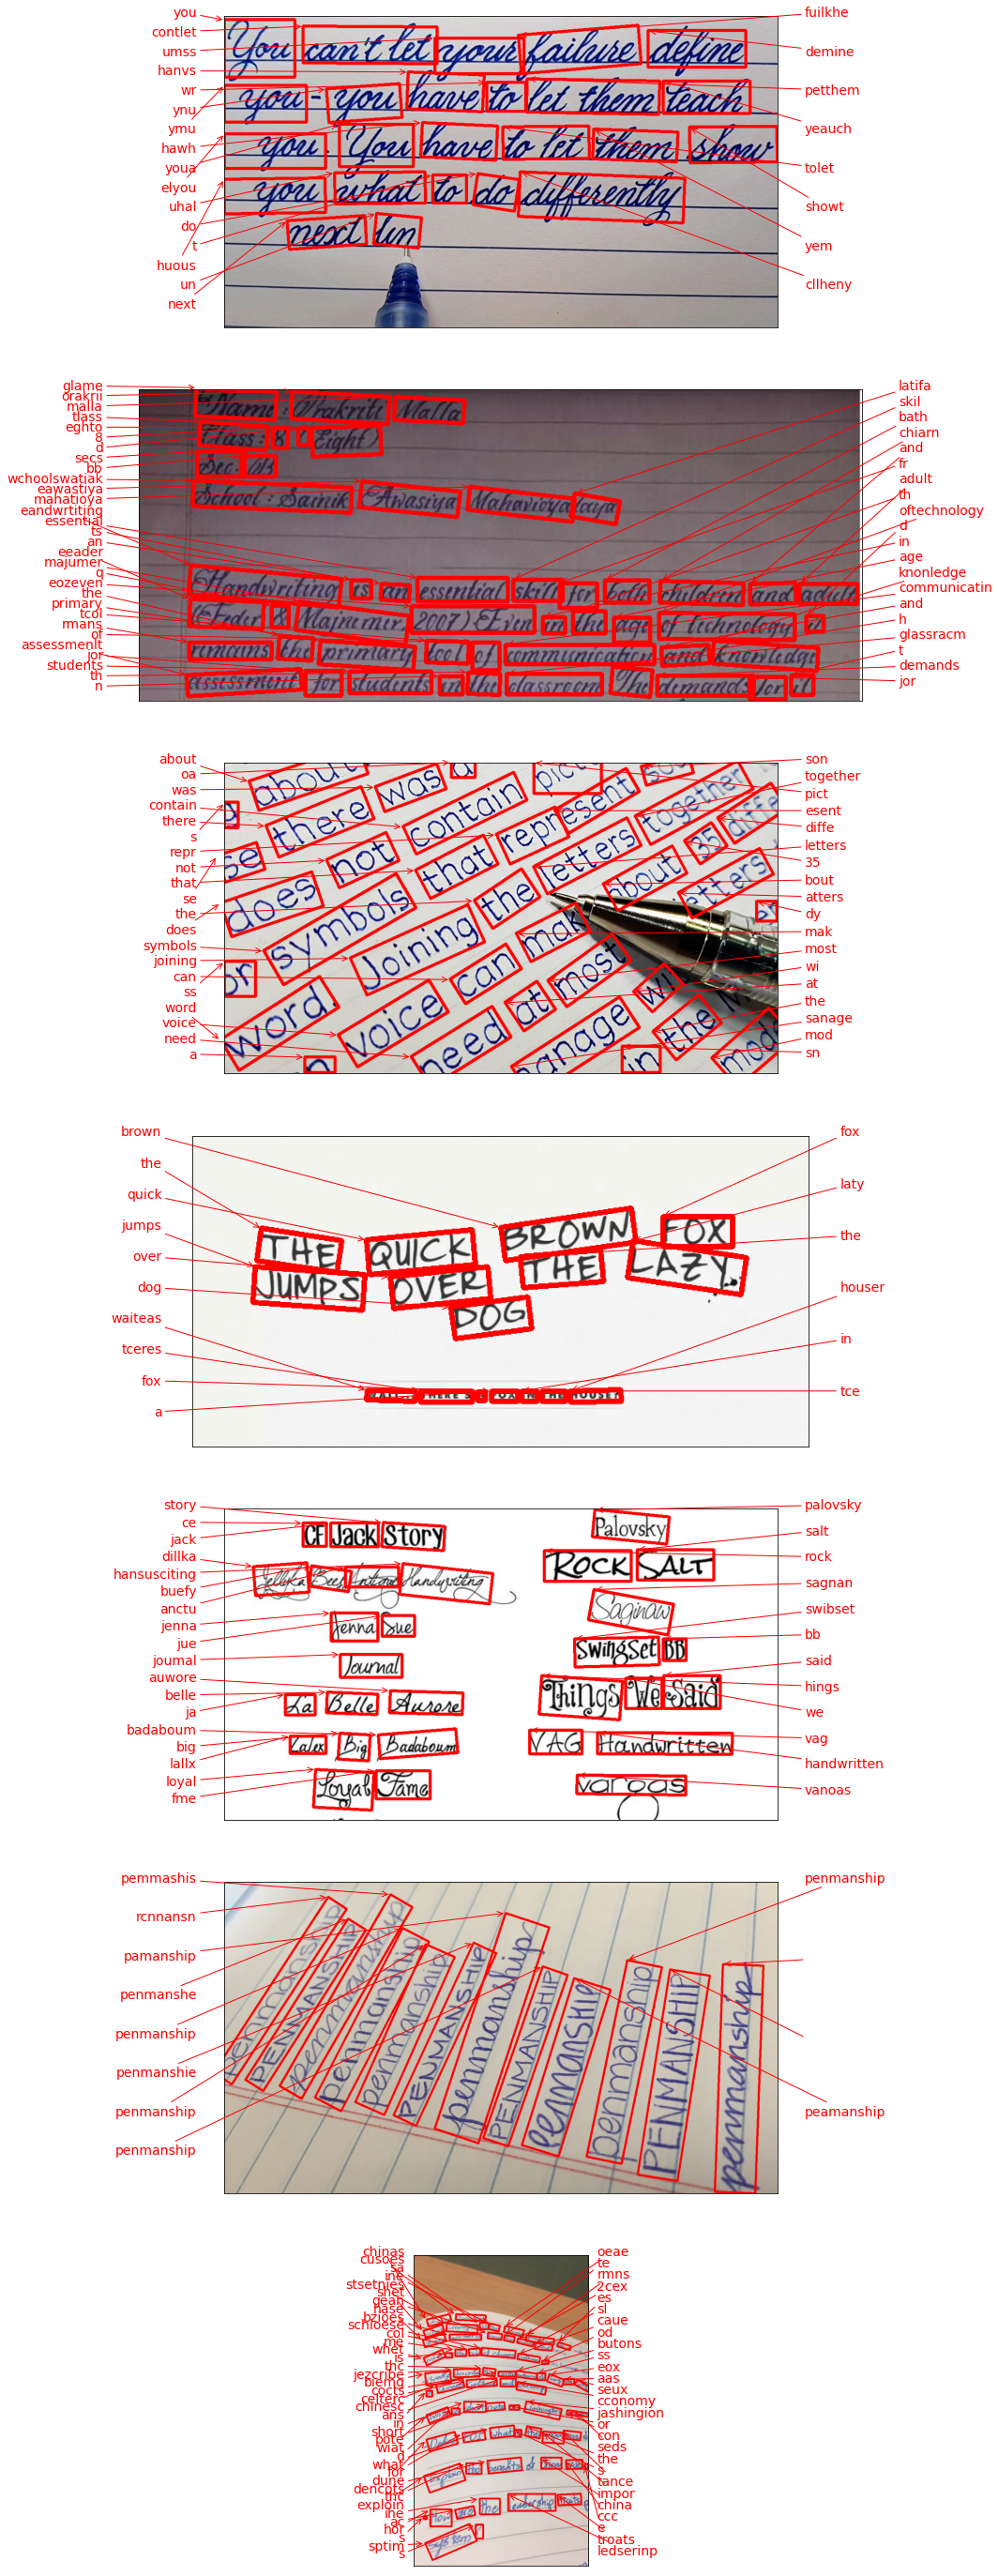

In [5]:
#plot the predictions
fig, axs = plt.subplots(nrows = len(images), figsize = (50, 50))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image = images[idx],
                                   predictions = prediction_groups[idx][0], ax = ax)

In [6]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

def crop_word_regions(image_path ='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    
    recognized_data = pytesseract.image_to_data(
        image, lang='eng',
        config = custom_oem_psm_config,
        output_type = Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
        
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python/images/cropped'

image_paths = [
    '/home/aiffel/aiffel/ocr_python/images/img1.jpg',
    '/home/aiffel/aiffel/ocr_python/images/img2.jpg',
    '/home/aiffel/aiffel/ocr_python/images/img3.jpg',
    '/home/aiffel/aiffel/ocr_python/images/img4.png',
    '/home/aiffel/aiffel/ocr_python/images/img5.jpg',
    '/home/aiffel/aiffel/ocr_python/images/img6.jpeg',
    '/home/aiffel/aiffel/ocr_python/images/img7.jpg', 
]

for path in image_paths:
    cropped_image_path_list = crop_word_regions(path, work_dir)


/home/aiffel/aiffel/ocr_python/images/cropped/0000.png
/home/aiffel/aiffel/ocr_python/images/cropped/0000.png
/home/aiffel/aiffel/ocr_python/images/cropped/0001.png
/home/aiffel/aiffel/ocr_python/images/cropped/0002.png
/home/aiffel/aiffel/ocr_python/images/cropped/0003.png
/home/aiffel/aiffel/ocr_python/images/cropped/0004.png
/home/aiffel/aiffel/ocr_python/images/cropped/0005.png
/home/aiffel/aiffel/ocr_python/images/cropped/0006.png
/home/aiffel/aiffel/ocr_python/images/cropped/0007.png
/home/aiffel/aiffel/ocr_python/images/cropped/0008.png
/home/aiffel/aiffel/ocr_python/images/cropped/0009.png
/home/aiffel/aiffel/ocr_python/images/cropped/0010.png
/home/aiffel/aiffel/ocr_python/images/cropped/0011.png
/home/aiffel/aiffel/ocr_python/images/cropped/0012.png
/home/aiffel/aiffel/ocr_python/images/cropped/0013.png
/home/aiffel/aiffel/ocr_python/images/cropped/0014.png
/home/aiffel/aiffel/ocr_python/images/cropped/0015.png
/home/aiffel/aiffel/ocr_python/images/cropped/0016.png
/home/aiff

In [7]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang = 'eng',
            config = custom_oem_psm_config,
            output_type = Output.DICT
        )
        print(recognized_data['text'])
    print("Done")
    
recognize_images(cropped_image_path_list)

_



a

pind?

[14 - Ope

wba

.

Th

om

LA

the

Arima,

Last Lt Hi OF <3

i

-

i

—_ 7

whe

» =

Hy.

Cole

ot

Chioag

Sofie

teen

eC

tee x


“a

_

“aA

Aes cribe

the

-.





~~

if)

ghort

ote

, Of)

at

ite @

(?


CoM sens,

FOL

What ts

_

yhoo

a


s the

;

goku. d

L sit?

de

Lenents:

ag

irc)

olde. \e

- EXP

_—

How

HE

the

gabe

ho

Traits

?

aff

tem:

aaa

cc LA

Done


### Step3. 테스트 결과 정리

테스트 결과 인식기간의 성능차이가 커 img1의 첫 문장을 얼마나 잘 인식했는지 비교함.
 - Google OCR API는 "You can't let yout failure define"를 정확히 인식함.
 - keras-ocr은 "you contlet umss fuilkhe demine"으로 인식함.
 - Tessearct는 전혀 알아볼 수 없는 결과를 제시함.

### Step4. 결과분석과 결론 제시

- 필기체 인식 테스트 결과 Google OCR API가 타의 추종을 불허하는 것으로 나타남. (Google OCR API를 선택할 수 밖에 없음)
- 특히 Tesseract는 거의 알아볼 수 없는 수준으로 나타나 매우 실망스러움.
- img1의 첫번째 줄만 보아도 알 수 있는데, 'You can't let your failure define you'를 완벽히 인식한 것은 Google OCR API밖에 없음.
- 다만 위 첫문장의 마지막 단어 'you'가 둘째줄에 있는데 이를 합쳐 하나의 문장으로 인식하지 못하는 것은 Google OCR API의 한계로 인식됨.

- 필기체 인식도 OCR을 통해 가능하고 필기체 읽기가 어려운 사람에게 도움을 줄 수 있음을 확인
- 평가시 문자 해독 능력을 기준으로 삼았으며, 인식기간의 성능이 극명하게 차이남을 확인
- 적은 이미지만으로도 각 OCR의 성능을 판별할 수 있었으며, 이를 통해 유효한 결론을 도출할 수 있었음